In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy import sparse
import anndata

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax
def import_matrix_as_anndata(
    matrix_path: str,
    barcodes_path: str,
    genes_path: str
) -> anndata.AnnData:
    name_column = 'gene_id'
    bc_name = 'barcode'
    df_barcodes = pd.read_csv(
        barcodes_path, index_col=0, header=None, names=[bc_name]
    )
    df_genes = pd.read_csv(
        genes_path, header=None, index_col=0, names=[name_column], sep='\t'
    )
    df_genes.index = df_genes.index.astype(str)
    mtx = scipy.io.mmread(matrix_path)
    adata = anndata.AnnData(X=mtx.tocsr(), var=df_barcodes, obs=df_genes)
    return adata.transpose()

plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = 'retina'

In [2]:
matrix_path = "truth_pbmc_5k_sims/truth.mtx"
genes_path = "genomes/human_CR_3.0.0/genes.tsv"
barcodes_path = "data/whitelists/10Xv3"

In [3]:
adata = import_matrix_as_anndata(matrix_path, barcodes_path, genes_path)

In [4]:
adata.X

<6794880x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 16776888 stored elements in Compressed Sparse Row format>

In [5]:
adata.X.astype(np.float64).sum()

49977803.0

In [6]:
knee = np.sort(nd(adata.X.astype(np.float64).sum(axis=1)))[::-1]

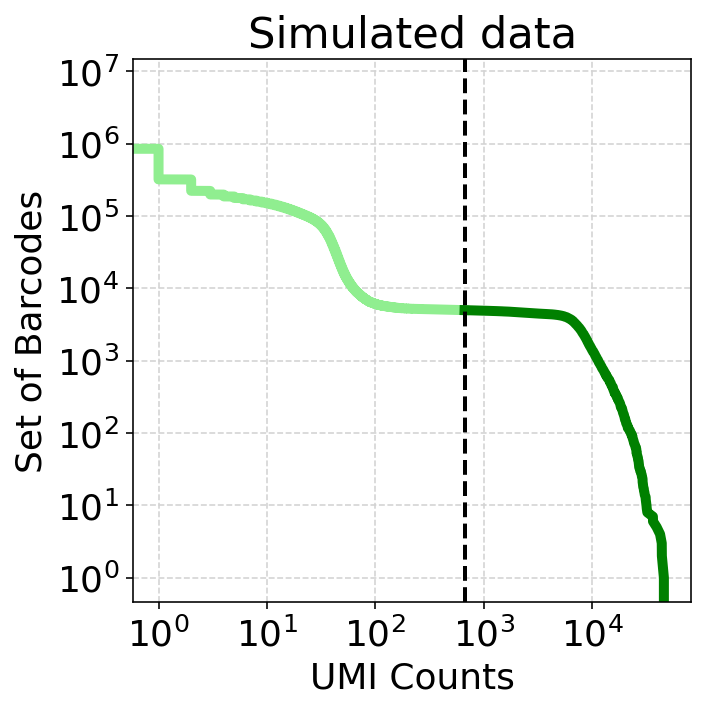

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))
target_y = 5000
threshold = x[target_y-1]

x_left = [xi for xi in x if xi < threshold]
y_left = [y[i] for i, xi in enumerate(x) if xi < threshold]
x_right = [xi for xi in x if xi >= threshold]
y_right = [y[i] for i, xi in enumerate(x) if xi >= threshold]

#ax.loglog(x, y, linewidth=5, color="g")
ax.loglog(x_left, y_left, linewidth=5, color="lightgreen")
ax.loglog(x_right, y_right, linewidth=5, color="g")
ax.grid(True, which="both", ls="--", color='lightgray')
ax.axvline(x=threshold, color='black', lw=2, ls="--")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
ax.set_title("Simulated data")

plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7])
plt.xticks([1e0,1e1,1e2,1e3,1e4])

plt.savefig("knee_plot_sim.png", dpi=300, bbox_inches = "tight")
plt.show()

In [8]:
threshold

667.0

In [9]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] >= threshold

In [10]:
adata[adata.obs["pass_count_filter"].values, :]

View of AnnData object with n_obs × n_vars = 5000 × 33538
    obs: 'cell_counts', 'pass_count_filter'

In [11]:
adata[adata.obs["pass_count_filter"].values, :].obs.index

Index(['AAACCCAAGCGTATGG', 'AAACCCAGTCCTACAA', 'AAACCCATCACCTCAC',
       'AAACGCTAGGGCATGT', 'AAACGCTGTAGGTACG', 'AAACGCTGTGTCCGGT',
       'AAACGCTGTGTGATGG', 'AAACGCTTCCTATGGA', 'AAACGCTTCTAGGCAT',
       'AAAGAACAGACTAGAT',
       ...
       'TTTGGTTGTCAAGCGA', 'TTTGGTTTCACCTACC', 'TTTGGTTTCACTGCTC',
       'TTTGGTTTCCGGTAAT', 'TTTGTTGAGCCATTTG', 'TTTGTTGCAGGTACGA',
       'TTTGTTGCAGTCTCTC', 'TTTGTTGGTAATTAGG', 'TTTGTTGTCCTTGGAA',
       'TTTGTTGTCGCACGAC'],
      dtype='object', name='barcode', length=5000)

In [12]:
barcodes_keep = np.array(adata[adata.obs["pass_count_filter"].values, :].obs.index)
np.savetxt("sim_barcodes.txt", barcodes_keep, fmt='%s')